In [30]:
import numpy as np
import scipy.sparse as sparse
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib notebook

[[ 0.04  0.04  0.04]
 [ 0.04  0.04  0.04]
 [ 0.04  0.04 -0.96]]
(5, 5) (5, 5) (25, 25)


<IPython.core.display.Javascript object>


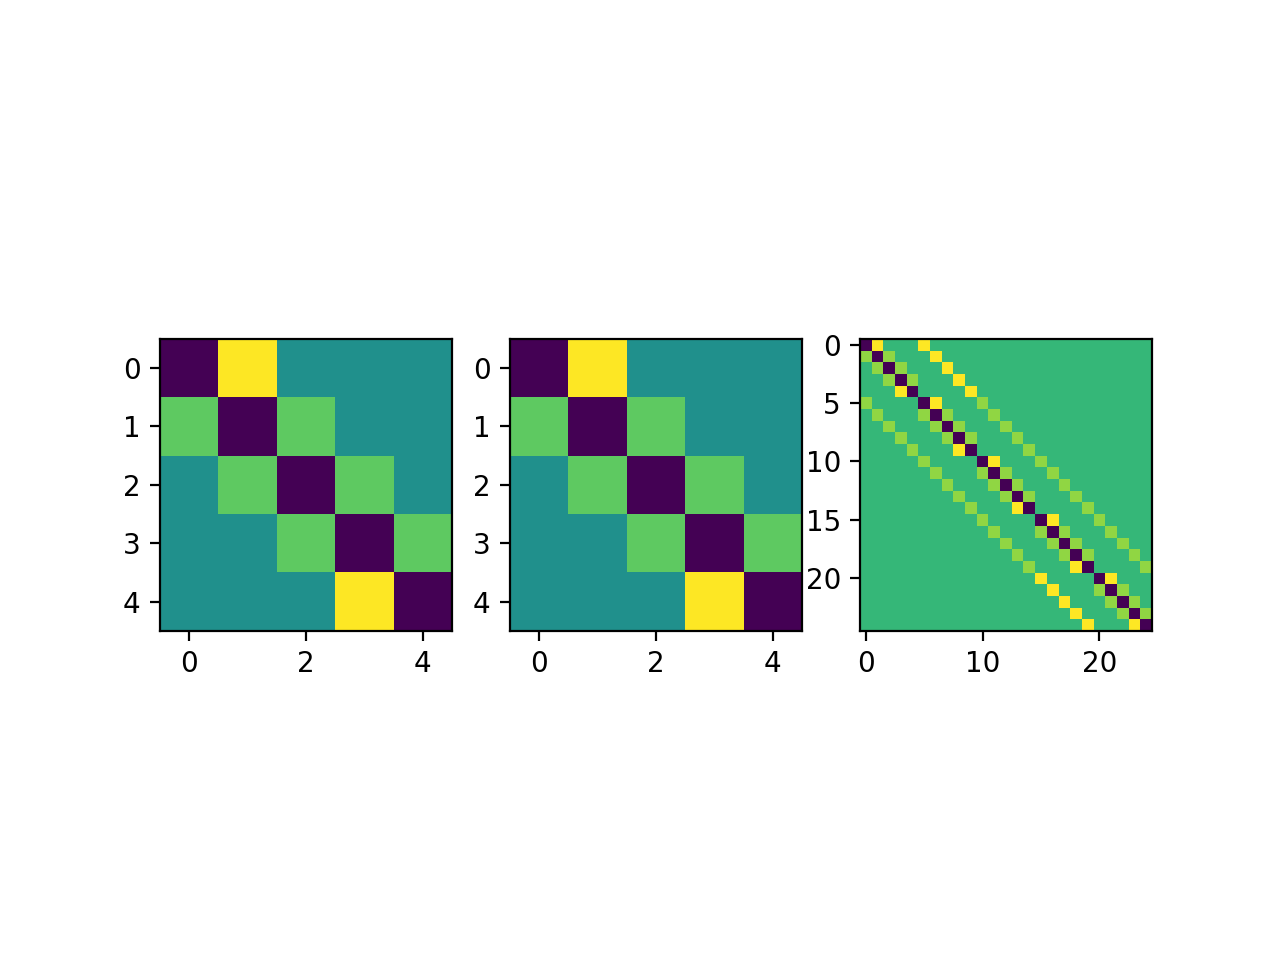

In [47]:
shape = (5, 5)
nx, ny = shape

charges = np.zeros(shape)
charges[:] = 1.0 / (nx * ny)
charges[nx // 2, ny // 2] = 1.0 / (nx * ny) - 1.0
print(charges[:3, :3])

charges = charges.flatten()

#Build Laplacian
ex  = np.append(np.ones(nx - 2), [2, 2])
ey  = np.append(np.ones(ny - 2), [2, 2])
Dxx = sparse.spdiags([ex, -2 * np.ones(nx), ex[::-1]], [-1, 0, 1], nx, nx)
Dyy = sparse.spdiags([ey, -2 * np.ones(ny), ey[::-1]], [-1, 0, 1], ny, ny)

L = sparse.kronsum(Dxx, Dyy).todense()
print(Dxx.shape, Dyy.shape, L.shape)
fig, axes = plt.subplots(1, 3)
axes[0].imshow(Dxx.todense())
axes[1].imshow(Dyy.todense())
axes[2].imshow(L)

In [41]:
###############

#Fourier method
rhofft = np.zeros(shape, dtype = float)
for i in range(shape[0]):
    rhofft[i,:] = fft.dct(charges.reshape(shape)[i,:], type = 1) / (shape[1] - 1.0)
for j in range(shape[1]):
    rhofft[:,j] = fft.dct(rhofft[:,j], type = 1) / (shape[0] - 1.0)

for i in range(shape[0]):
    for j in range(shape[1]):
        factor = 2.0 * (np.cos((np.pi * i) / (shape[0] - 1)) + np.cos((np.pi * j) / (shape[1] - 1)) - 2.0)
        if factor != 0.0:
            rhofft[i, j] /= factor
        else:
            rhofft[i, j] = 0.0

potential = np.zeros(shape, dtype = float)
for i in range(shape[0]):
    potential[i,:] = 0.5 * fft.dct(rhofft[i,:], type = 1)
for j in range(shape[1]):
    potential[:,j] = 0.5 * fft.dct(potential[:,j], type = 1)

################
charges = charges.reshape(shape)
charges_hat = (L @ potential.flatten()).reshape(shape)
print(np.sum(np.abs(charges_hat - charges)))
# print(potential)

0.1479591836734695


<IPython.core.display.Javascript object>


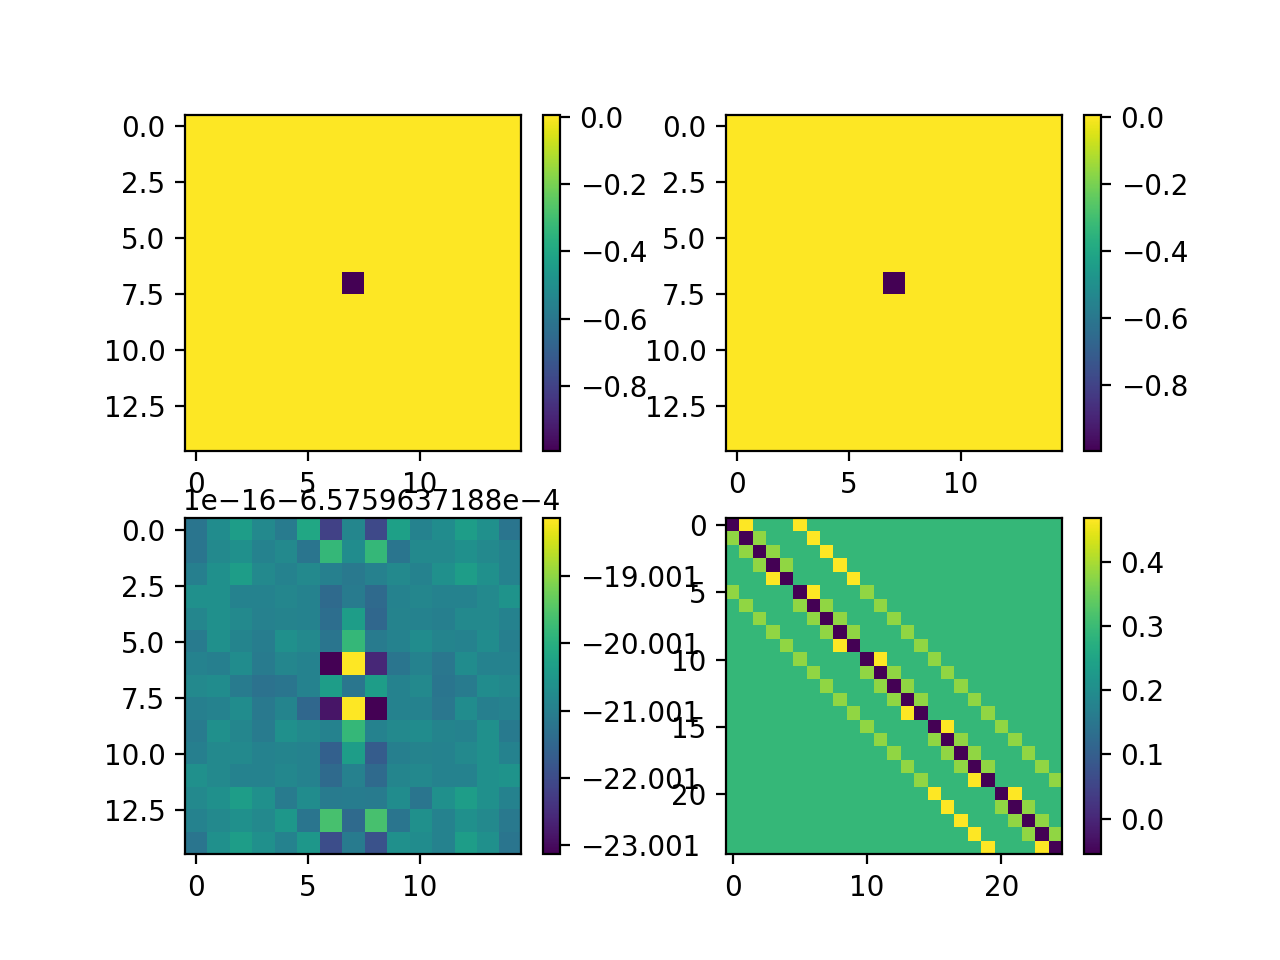

In [42]:
fig, axes = plt.subplots(2, 2)
axr = axes.ravel()
axim = axr[0].imshow(charges_hat)
fig.colorbar(axim, ax=axr[0])
axim = axr[1].imshow(charges)
fig.colorbar(axim, ax=axr[1])
axim = axr[2].imshow(charges - charges_hat)
fig.colorbar(axim, ax=axr[2])
axim = axr[3].imshow(potential)
fig.colorbar(axim, ax=axr[3])

In [34]:
charges[:4, :4]

array([[0.00444444, 0.00444444, 0.00444444, 0.00444444],
       [0.00444444, 0.00444444, 0.00444444, 0.00444444],
       [0.00444444, 0.00444444, 0.00444444, 0.00444444],
       [0.00444444, 0.00444444, 0.00444444, 0.00444444]])

# Diagonalizing operators:

In [48]:
import scipy.linalg as LA


In [49]:
# Example from Strang, 1999
A0 = LA.circulant([2,-1,0,-1])
print(A0)

[[ 2 -1  0 -1]
 [-1  2 -1  0]
 [ 0 -1  2 -1]
 [-1  0 -1  2]]


In [51]:
# LA.LU
Lam, V = LA.eig(A0)
print(Lam)
print(V)

[-6.66133815e-16+0.j  2.00000000e+00+0.j  4.00000000e+00+0.j
  2.00000000e+00+0.j]
[[ 5.00000000e-01 -7.07106781e-01  5.00000000e-01  4.70869024e-17]
 [ 5.00000000e-01  3.64686731e-16 -5.00000000e-01 -7.07106781e-01]
 [ 5.00000000e-01  7.07106781e-01  5.00000000e-01  2.66931589e-16]
 [ 5.00000000e-01  1.70419970e-16 -5.00000000e-01  7.07106781e-01]]


In [56]:
print(V[:, 0])
LA.norm(V, axis=1)
LA.norm(V[:, 0])

[0.5 0.5 0.5 0.5]


1.0

In [57]:
1/np.sqrt(2)

0.7071067811865475

# Periodic A: Diagonlized by the DFT
The columns of the N = 4 DFT matrix are eigenvectors of the $A_0$ matrix.

Using $\omega = e^{i 2 \pi / n}$,

In [58]:
N = A0.shape[0]
omega = np.exp(1j*2*np.pi / N)
print(omega)

(6.123233995736766e-17+1j)


$v_k = \omega^{jk}, j \in {0,1,\ldots,N-1}$ 

In [68]:
Vs = []
for j in range(N):
    v = omega ** (j * np.arange(0, N))
    Vs.append(v)
    print(f"{j = },  {np.around(v, 2)}")


j = 0,  [1.+0.j 1.+0.j 1.+0.j 1.+0.j]
j = 1,  [ 1.+0.j  0.+1.j -1.+0.j -0.-1.j]
j = 2,  [ 1.+0.j -1.+0.j  1.-0.j -1.+0.j]
j = 3,  [ 1.+0.j -0.-1.j -1.+0.j  0.+1.j]


To see eigenvalues, divide the product $Av$ by $v$:

In [70]:
for j in range(N):
    lam = np.around((A0 @ Vs[j]) / Vs[j], 2)
    print(f"{j=}, {lam}")


j=0, [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
j=1, [2.+0.j 2.-0.j 2.-0.j 2.-0.j]
j=2, [4.-0.j 4.-0.j 4.+0.j 4.+0.j]
j=3, [2.+0.j 2.+0.j 2.+0.j 2.-0.j]


In [73]:
print(V[:, 1])

[-7.07106781e-01  3.64686731e-16  7.07106781e-01  1.70419970e-16]


In [74]:
LA.eig?

In [81]:
import numpy.linalg as NLA
L2, V2 = NLA.eig(A0.astype(complex))

In [83]:
np.around(V2, 2)

array([[ 0.5-0.j  ,  0.5+0.j  ,  0.7+0.j  ,  0.1+0.01j],
       [ 0.5+0.j  , -0.5-0.j  ,  0.1-0.01j, -0.7-0.j  ],
       [ 0.5-0.j  ,  0.5+0.j  , -0.7-0.j  , -0.1-0.01j],
       [ 0.5+0.j  , -0.5-0.j  , -0.1+0.01j,  0.7+0.j  ]])